## Notebook to illustrate the application of the probablistic jerk finder to multiple jerks.

#### Here is an assumed underlying piecewise linear time dependence with a change in slope at t=25, t=40 and t=60:

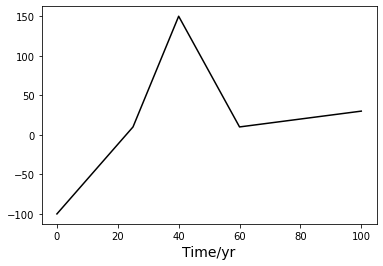

In [1]:
import matplotlib.pyplot as plt
import numpy as np
time_for_plotting = np.linspace(0,100,100,endpoint=True)
plt.figure()
plt.plot([0,25,40,60,100],[-100,10,150,10,30],'k');
plt.xlabel('Time/yr',fontsize=14)
plt.savefig('example2_raw_signal.pdf',bbox_inches='tight')

#### Now we sample the timeseries at NUM_DATA points (here, assumed equally spaced) and add noise (assumed normally distributed with known standard deviation)

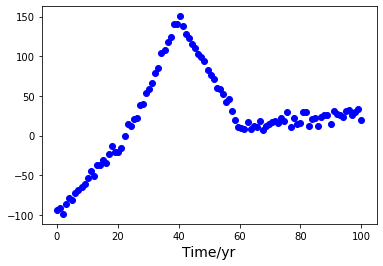

In [2]:
plt.figure()
np.random.seed(seed = 10)
NUM_DATA = 100
TIMES = np.linspace(0,100,NUM_DATA,dtype=float)
delta_Y = 5 * np.ones(NUM_DATA)
Y = np.interp(TIMES,[0,25,40,60,100],[-100,10,150,10,30]) + np.random.normal(loc=0,scale=delta_Y)
plt.plot(TIMES, Y,'ob');
plt.xlabel('Time/yr',fontsize=14)
plt.savefig('example2_noised_signal.pdf',bbox_inches='tight')

In [3]:
import os
import sys
sys.path.append( os.path.abspath('..') )
from jerks import jerks
import numpy as np

# Define parameters for method:

Y_MIN = -200
Y_MAX = 200
discretise_size = 100

TIMES_MIN = 0.0
TIMES_MAX = 100.0
K_MIN = 0
K_MAX = 100
sigmas = np.array([10,5,10],dtype = float)

# sigma_change_value = sigmas(1)
# sigma_move = sigmas(2)
# sigma_birth = sigmas(3)

THIN = 100
NBINS = 100
credible = 95
RUNNING_MODE = 1
burn_in = 10000
NSAMPLE = 2000000+burn_in
time_intervals_nbins = 99  #collect change point histogram over 101 bins for the 100 time units, f
#[0.5,1.5], ....[98.5, 99.5]
time_intervals_edges = np.linspace(TIMES_MIN+0.5, TIMES_MAX-0.5, time_intervals_nbins+1, endpoint = True)

# define spaces for outputs
Acceptance_rates=np.zeros(4)
AV = np.zeros(discretise_size,dtype=float)
SUP = np.zeros(discretise_size,dtype=float)
INF = np.zeros(discretise_size,dtype=float)
MEDIAN = np.zeros(discretise_size,dtype=float)
MODE = np.zeros(discretise_size,dtype=float)
CP_hist = np.zeros( time_intervals_nbins,dtype=int )
MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
N_CP_hist = np.zeros( K_MAX-K_MIN+1, dtype=int)
delta_slope = np.zeros( time_intervals_nbins,dtype=int )

(Acceptance_rates, SUP, INF,AV, MEDIAN, MODE, CP_hist,delta_slope, MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
 sigmas=sigmas, burn_in=burn_in, 
 nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=Y, delta_y=delta_Y, 
 y_min=Y_MIN, y_max=Y_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
 k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
 thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)


print('Acceptance rates should ideally be 10-40%')
print(Acceptance_rates)

Acceptance rates should ideally be 10-40%
[18.01070023  6.39791489  2.44849229  2.45188308]


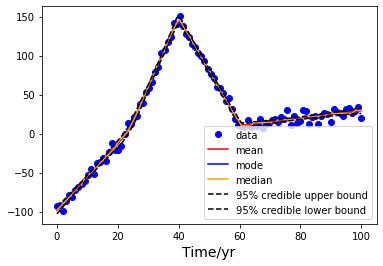

In [4]:
plt.figure()
plt.plot(TIMES,Y,'bo', label='data')
plt.plot(time_for_plotting,AV,'r', label='mean')
plt.plot(time_for_plotting,MODE, 'b',  label='mode')
plt.plot(time_for_plotting,MEDIAN, 'orange',  label='median')
plt.plot(time_for_plotting, SUP,'k--',  label='95% credible upper bound')
plt.plot(time_for_plotting,INF, 'k--',  label='95% credible lower bound')
plt.legend(loc='lower right')
plt.xlabel('Time/yr',fontsize=14)
plt.savefig('example2_posterior.pdf',bbox_inches='tight')

#### Histogram of vertex probability with original time series. The vertical scale indicates the probability that an internal vertex is in each (1 time unit) bin:

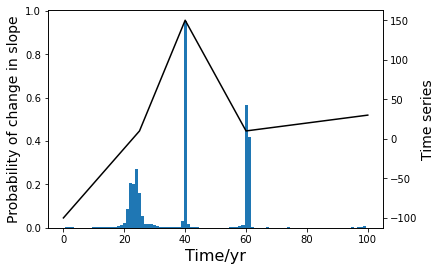

In [5]:
# Binning in code:
# bins are 0-1, 1-2, 2-3, 3-4, etc. with left edges at 0,1,2,3,4,...
# 
fig, ax = plt.subplots(1)
fac = (NSAMPLE-burn_in)/THIN
left_edges = time_intervals_edges[:time_intervals_nbins] # use the left edges
plt.bar(left_edges, CP_hist/fac, align='edge', 
        width  = time_intervals_edges[1:] - time_intervals_edges[0:time_intervals_nbins])
ax2 = ax.twinx()
plt.plot([0,25,40,60,100],[-100,10,150,10,30],'k');
ax.set_xlabel('Time/yr',fontsize=16)
ax.set_ylabel('Probability of change in slope',fontsize=14)
ax2.set_ylabel('Time series',fontsize=14)
plt.savefig('example2_jerk_timing.pdf',bbox_inches='tight')

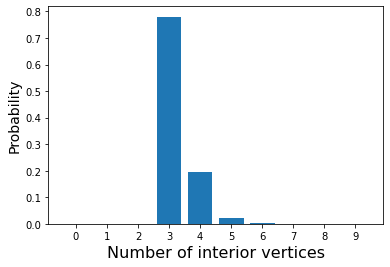

In [6]:
plt.figure()
plt.bar(np.arange(0,10),N_CP_hist[0:10]/np.sum(N_CP_hist),align='center',tick_label=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Number of interior vertices',fontsize=16)
plt.ylabel('Probability',fontsize=14)
plt.savefig('example2_number_vertices.pdf',bbox_inches='tight')

In [9]:
from scipy.signal import find_peaks
peaks,_ = find_peaks(CP_hist/fac, height=0.1)
for p in peaks:
    print('Most probable change in slope is between {0:f} and {1:f}'.
      format(left_edges[p], left_edges[p+1]))

Most probable change in slope is between 23.500000 and 24.500000
Most probable change in slope is between 39.500000 and 40.500000
Most probable change in slope is between 59.500000 and 60.500000


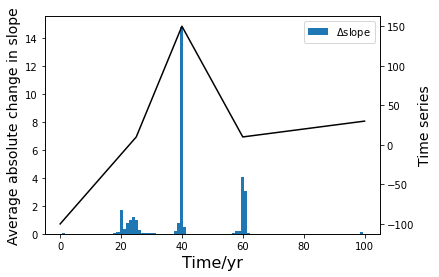

In [8]:
# Bin by sum of abs delta slopes:
# 
fig,ax1 = plt.subplots(1)
fac = (NSAMPLE-burn_in)/THIN
left_edges = time_intervals_edges[:time_intervals_nbins] # use the left edges
ax1 = plt.gca()
plt.bar(left_edges, delta_slope, align='edge', 
        width = time_intervals_edges[1:] - time_intervals_edges[0:time_intervals_nbins],
        label=r'$\Delta$slope')
ax2 = ax1.twinx()
ax2.plot([0,25,40,60,100],[-100,10,150,10,30],'k',label="True timeseries");
ax1.set_xlabel('Time/yr',fontsize=16)
ax1.set_ylabel('Average absolute change in slope',fontsize=14)
ax2.set_ylabel('Time series',fontsize=14)

# Plot actual change in slope
delta = 1e-6
TIMES2 = np.array([25,40,60])
Y0 = np.interp(TIMES2-delta,[0,25,40,60,100],[-100,10,150,10,30])
Y1 = np.interp(TIMES2,[0,25,40,60,100],[-100,10,150,10,30])
Y2 = np.interp(TIMES2+delta,[0,25,40,60,100],[-100,10,150,10,30])
slope2= (Y2-Y1)/delta
slope1 = (Y1-Y0)/delta
#ax1.plot(TIMES2, abs(slope2-slope1),'bs',label=r'Actual $\Delta$slope')
ax1.legend()


plt.savefig('example2_jerk_timing_delta_slope.pdf',bbox_inches='tight')

#### Larger bins

In [11]:
import os
import sys
sys.path.append( os.path.abspath('..') )
from jerks import jerks
import numpy as np

# Define parameters for method:

Y_MIN = -200
Y_MAX = 200
discretise_size = 100

TIMES_MIN = 0.0
TIMES_MAX = 100.0
K_MIN = 0
K_MAX = 100
sigmas = np.array([10,5,10],dtype = float)

# sigma_change_value = sigmas(1)
# sigma_move = sigmas(2)
# sigma_birth = sigmas(3)

THIN = 100
NBINS = 100
credible = 95
RUNNING_MODE = 1
burn_in = 10000
NSAMPLE = 2000000+burn_in
time_intervals_nbins = 9  #collect change point histogram over 101 bins for the 100 time units, f
#[0.5,1.5], ....[98.5, 99.5]
time_intervals_edges = np.linspace(TIMES_MIN+0.5, TIMES_MAX-0.5, time_intervals_nbins+1, endpoint = True)

# define spaces for outputs
Acceptance_rates=np.zeros(4)
AV = np.zeros(discretise_size,dtype=float)
SUP = np.zeros(discretise_size,dtype=float)
INF = np.zeros(discretise_size,dtype=float)
MEDIAN = np.zeros(discretise_size,dtype=float)
MODE = np.zeros(discretise_size,dtype=float)
CP_hist = np.zeros( time_intervals_nbins,dtype=int )
MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
N_CP_hist = np.zeros( K_MAX-K_MIN+1, dtype=int)
delta_slope = np.zeros( time_intervals_nbins,dtype=int )

(Acceptance_rates, SUP, INF,AV, MEDIAN, MODE, CP_hist,delta_slope, MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
 sigmas=sigmas, burn_in=burn_in, 
 nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=Y, delta_y=delta_Y, 
 y_min=Y_MIN, y_max=Y_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
 k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
 thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)


print('Acceptance rates should ideally be 10-40%')
print(Acceptance_rates)

Acceptance rates should ideally be 10-40%
[18.13540077  6.42003679  2.50352526  2.50659227]


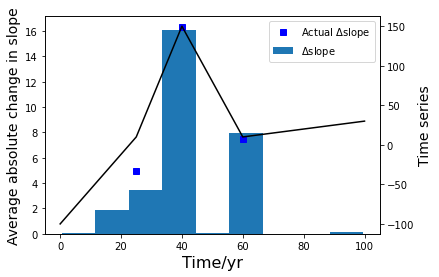

In [12]:
# Bin by sum of abs delta slopes:
# 
fig,ax1 = plt.subplots(1)
fac = (NSAMPLE-burn_in)/THIN
left_edges = time_intervals_edges[:time_intervals_nbins] # use the left edges
ax1 = plt.gca()
plt.bar(left_edges, delta_slope, align='edge', 
        width = time_intervals_edges[1:] - time_intervals_edges[0:time_intervals_nbins],
        label=r'$\Delta$slope')
ax2 = ax1.twinx()
ax2.plot([0,25,40,60,100],[-100,10,150,10,30],'k',label="True timeseries");
ax1.set_xlabel('Time/yr',fontsize=16)
ax1.set_ylabel('Average absolute change in slope',fontsize=14)
ax2.set_ylabel('Time series',fontsize=14)

# Plot actual change in slope
delta = 1e-6
TIMES2 = np.array([25,40,60])
Y0 = np.interp(TIMES2-delta,[0,25,40,60,100],[-100,10,150,10,30])
Y1 = np.interp(TIMES2,[0,25,40,60,100],[-100,10,150,10,30])
Y2 = np.interp(TIMES2+delta,[0,25,40,60,100],[-100,10,150,10,30])
slope2= (Y2-Y1)/delta
slope1 = (Y1-Y0)/delta
ax1.plot(TIMES2, abs(slope2-slope1),'bs',label=r'Actual $\Delta$slope')
ax1.legend()



#### Non uniform bins

In [60]:
import os
import sys
sys.path.append( os.path.abspath('..') )
from jerks import jerks
import numpy as np

# Define parameters for method:

Y_MIN = -200
Y_MAX = 200
discretise_size = 100

TIMES_MIN = 0.0
TIMES_MAX = 100.0
K_MIN = 0
K_MAX = 100
sigmas = np.array([10,5,10],dtype = float)

# sigma_change_value = sigmas(1)
# sigma_move = sigmas(2)
# sigma_birth = sigmas(3)

THIN = 100
NBINS = 100
credible = 95
RUNNING_MODE = 1
burn_in = 10000
NSAMPLE = 2000000+burn_in

time_intervals_edges = np.array([0,10,15,25,50,52,58,65,75,90,100])
time_intervals_nbins = time_intervals_edges.shape[0]-1  

# define spaces for outputs
Acceptance_rates=np.zeros(4)
AV = np.zeros(discretise_size,dtype=float)
SUP = np.zeros(discretise_size,dtype=float)
INF = np.zeros(discretise_size,dtype=float)
MEDIAN = np.zeros(discretise_size,dtype=float)
MODE = np.zeros(discretise_size,dtype=float)
CP_hist = np.zeros( time_intervals_nbins,dtype=int )
MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
N_CP_hist = np.zeros( K_MAX-K_MIN+1, dtype=int)
delta_slope = np.zeros( time_intervals_nbins,dtype=int )

(Acceptance_rates, SUP, INF,AV, MEDIAN, MODE, CP_hist,delta_slope, MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
 sigmas=sigmas, burn_in=burn_in, 
 nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=Y, delta_y=delta_Y, 
 y_min=Y_MIN, y_max=Y_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
 k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
 thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)


print('Acceptance rates should ideally be 10-40%')
print(Acceptance_rates)



Acceptance rates should ideally be 10-40%
[18.13540077  6.42003679  2.50352526  2.50659227]


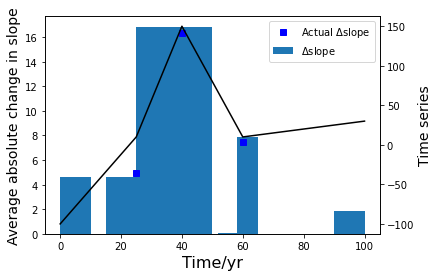

In [62]:
# Bin by sum of abs delta slopes:
# 
fig,ax1 = plt.subplots(1)
fac = (NSAMPLE-burn_in)/THIN
left_edges = time_intervals_edges[:time_intervals_nbins] # use the left edges
ax1 = plt.gca()
plt.bar(left_edges, delta_slope, align='edge', 
        width = time_intervals_edges[1:] - time_intervals_edges[0:time_intervals_nbins],
        label=r'$\Delta$slope')
ax2 = ax1.twinx()
ax2.plot([0,25,40,60,100],[-100,10,150,10,30],'k',label="True timeseries");
ax1.set_xlabel('Time/yr',fontsize=16)
ax1.set_ylabel('Average absolute change in slope',fontsize=14)
ax2.set_ylabel('Time series',fontsize=14)

# Plot actual change in slope
delta = 1e-6
TIMES2 = np.array([25,40,60])
Y0 = np.interp(TIMES2-delta,[0,25,40,60,100],[-100,10,150,10,30])
Y1 = np.interp(TIMES2,[0,25,40,60,100],[-100,10,150,10,30])
Y2 = np.interp(TIMES2+delta,[0,25,40,60,100],[-100,10,150,10,30])
slope2= (Y2-Y1)/delta
slope1 = (Y1-Y0)/delta
ax1.plot(TIMES2, abs(slope2-slope1),'bs',label=r'Actual $\Delta$slope')
ax1.legend()


